# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

Описание данных:
* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

## Откройте и изучите файл

In [2]:
#откроем таблицу
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
#выведем первые 15 строк
df.head(15)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [4]:
#посмотрим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
#проверим на наличие полных дубликатов
df.duplicated().sum()

0

Заменим тип данных в столбцах `calls` и `messages`, т.к они содержат только целые числа

In [6]:
df['calls'] = df['calls'].astype('int')
df['messages'] = df['messages'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


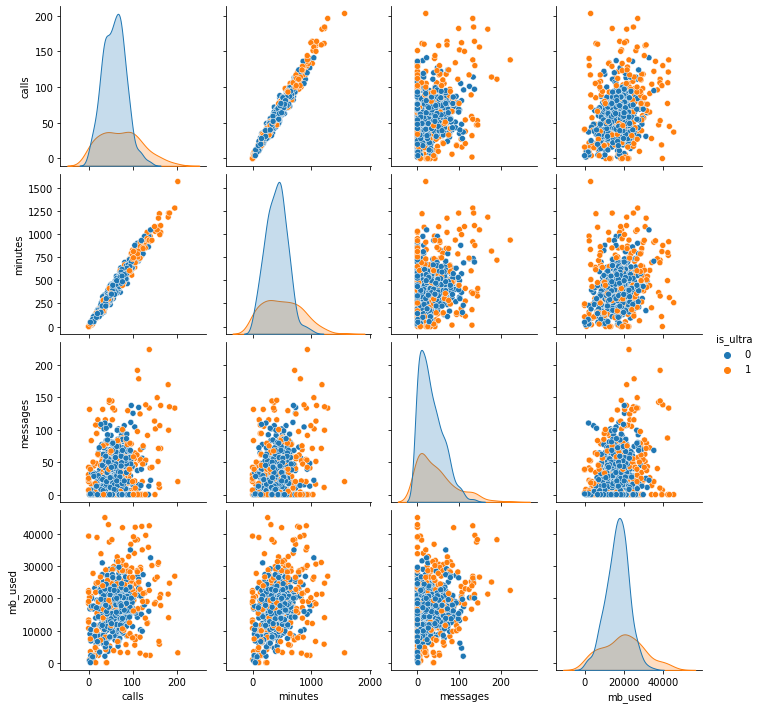

In [24]:
sns.pairplot(df, hue='is_ultra');

Данные не содержат пропусков и дубликатов и готовы к работе. Изменил тип данных в столбцах `calls` и `messages`, т.к они содержат только целые числа

## Разбейте данные на выборки

Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: `обучающую`, `валидационную` и `тестовую`. Исходные данные разбивают в соотношении `3:1:1`.

Размер обучающей выборки - `60%` от исходных данных.

Валидационная и тестовая по `20%` от исходных данных.

In [8]:
#60% выделяем под обучающую выборку
df_train, df_valid = train_test_split(df, test_size=.4, random_state=12345)
#оставшиеся 40% разделим пополам на валидационную и тестопую выборки
df_valid, df_test = train_test_split(df_valid, test_size=.5, random_state=12345)

In [9]:
for df_name, df in {'train': df_train, 'valid': df_valid, 'test': df_test}.items():
    print(f'Размер {df_name} выборки', df.shape) 

Размер train выборки (1928, 5)
Размер valid выборки (643, 5)
Размер test выборки (643, 5)


Вывод:

Разделили данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1

* Размер обучающей выборки составил 1928 строк - 60%
* Размер валидационной выборки составил 643 строк - 20%
* Размер тестовой выборки составил 643 строк - 20%

## Исследуйте модели

Определим признаки для выборок

In [10]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

### Дерево решений

In [11]:
best_model_dtc = None
best_result = 0
best_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if result > best_result:
        best_model_dtc = model
        best_result = result
        best_depth = depth
        
print(f'Accuracy: {best_result}, глубина дерева: {best_depth}')

Accuracy: 0.7853810264385692, глубина дерева: 3


### Случайный лес

In [12]:
best_model_rfc = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        if result > best_result:
            best_model_rfc = model
            best_result = result
            best_est = est
            best_depth = depth

print(f'Accuracy: {best_result}, количество деревьев: {best_est}, максимальная глубина: {best_depth}')

Accuracy: 0.8087091757387247, количество деревьев: 40, максимальная глубина: 8


### Логистическая регрессия

In [13]:
model_lr = LogisticRegression(random_state = 12345, solver='lbfgs', max_iter=1000)
model_lr.fit(features_train, target_train)
print(f'Accuracy: {model_lr.score(features_valid, target_valid)}')

Accuracy: 0.7107309486780715


Вывод:

Лучший результат показал `Случайный лес` с количеством деревьев: 40 и максимальной глубиной: 8

## Проверьте модель на тестовой выборке

### Дерево решений

In [14]:
predictions_test_dtc = best_model_dtc.predict(features_test)
print('Accuracy:', accuracy_score(predictions_test_dtc, target_test))

Accuracy: 0.7791601866251944


### Случайный лес

In [15]:
predictions_test_rfc = best_model_rfc.predict(features_test)
print('Accuracy:', accuracy_score(predictions_test_rfc, target_test))

Accuracy: 0.7962674961119751


### Логистическая регрессия

In [16]:
print('Accuracy:', model_lr.score(features_test, target_test))

Accuracy: 0.6842923794712286


Значения accuracy на тестовой выборке не сильно отличается от accuracy на обучающей выборке, что говорит об отсутствии переобучения.

Лучшей моделью является - `Случайный лес`

## (бонус) Проверьте модели на адекватность

In [17]:
model_dc = DummyClassifier(random_state=12345)
model_dc.fit(features_train, target_train)
print('Accuracy:', model_dc.score(features_valid, target_valid))

Accuracy: 0.7060653188180405


In [18]:
model_dc.fit(features_test, target_test)
print('Accuracy:', model_dc.score(features_test, target_test))

Accuracy: 0.6842923794712286


Все модели кроме `логической регрессии` показали значения accuracy больше чем фиктивный классификатор `DummyClassifier`

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
